In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.tourism.utsmodel import SARIMAXData
from src.tourism._data import ScaledLogitScalar

In [2]:
target_dir = os.getcwd() + "/data/tourism/palau/intermediate/"
palau = pd.read_csv(target_dir + 'palau_merged.csv').drop("Unnamed: 0", axis=1)
palau.columns = [col.replace(" ", "_").lower() for col in palau.columns]
palau.head(5)

,year,month,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total
0,2019,1,13048.0,13048.0,75.0,75.0,2019-01-01,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0
1,2019,2,13281.0,13281.0,74.0,74.0,2019-02-01,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0
2,2019,3,12870.0,12870.0,73.0,73.0,2019-03-01,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0
3,2019,4,10806.0,10806.0,64.0,64.0,2019-04-01,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0
4,2019,5,11472.0,11472.0,67.0,67.0,2019-05-01,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0


In [3]:
pt = SARIMAXData("tonga")
pt.read_and_merge()

In [44]:
import numpy as np

class CustomScaler:
    @staticmethod
    def scaledlogit_transform(series):
        upper = series.max(axis=0) + 1
        lower = series.min(axis=0) - 1
        scaled_logit = np.log((series - lower) / (upper - series))
        return scaled_logit

    @staticmethod
    def inverse_scaledlogit(trans_series, upper, lower):
        exp = np.exp(trans_series)
        inv_series = (((upper - lower) * exp) / (1 + exp)) + lower
        return inv_series

    def fit(self, X):
        self.upper_ = X.max(axis=0) + 1
        self.lower_ = X.min(axis=0) - 1

    def transform(self, X):
        return self.scaledlogit_transform(X)

    def inverse_transform(self, trans_X):
        return self.inverse_scaledlogit(trans_X, self.upper_, self.lower_)


In [59]:
c = CustomScaler()
c.fit(data)
data_scaled = c.transform(data)

In [30]:
palau = pt.data
data = palau[["total", "stringency_index", "tonga_flights", "tonga_hotel", "tonga_travel"]]
data.head(5)

,total,stringency_index,tonga_flights,tonga_hotel,tonga_travel
0,3158,0.0,1.023708,1.177964,0.530498
1,2379,0.0,0.722348,1.372753,0.725430
2,3134,0.0,0.816930,1.415719,0.367724
3,2818,0.0,0.595805,1.081875,0.205626
4,3670,0.0,1.128415,1.849573,0.931053


In [15]:
from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Bidirectional
from sklearn.preprocessing import MinMaxScaler

def lstm_tune(X,
              y,
              neurons,
              recurrent_dropout,
              n_steps,
              dropout=0.2,
              nb_epoch=100):
    loss_df = pd.DataFrame()
    # prepare model
    model = Sequential()
    model.add(
        LSTM(neurons,
             dropout=dropout,
             recurrent_dropout=recurrent_dropout,
             kernel_regularizer=regularizers.l2(0.001),
             return_sequences=False,
             input_shape=(n_steps, X.shape[-1])))
    model.add(BatchNormalization())
    model.add(Dense(16, activation="relu"))
    model.add(Dense(n_features))
    model.compile(loss='mse', optimizer='RMSprop')
    # fit model
    train_mse, val_mse = list(), list()
    for i in range(nb_epoch):
        print("Epoch " + str(i + 1) + " out of " + str(nb_epoch))
        lstm_model = model.fit(X,
                               y,
                               epochs=1,
                               shuffle=True,
                               validation_data=(X_test, y_test))
        train_mse.append(float(lstm_model.history["loss"][0]))
        val_mse.append(float(lstm_model.history["val_loss"][0]))
        model.reset_states()
    loss_df['train'], loss_df['validation'] = train_mse, val_mse
    return loss_df

In [63]:
# Specify the number of time steps and features
n_steps = 12
n_features = data.shape[1]

# # # Scale the data
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(0.95 * len(data))
train_data, test_data = data_scaled[:train_size,:], data_scaled[train_size-n_steps:,:]

# Define the training and testing data sets
X_train, y_train = [], []
for i in range(n_steps, len(train_data)):
    X_train.append(train_data[i-n_steps:i,:])
    y_train.append(train_data[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i-n_steps:i,:])
    y_test.append(test_data[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

InvalidIndexError: (slice(None, 136, None), slice(None, None, None))

In [17]:
losses = pd.DataFrame()
rds = [0.2, 0.4, 0.5]
for rd in rds:
    print(f"Recurrent_Dropout = {rd}:")
    loss = lstm_tune(X_train, y_train, recurrent_dropout=rd, n_steps=n_steps, 
                     neurons=64, nb_epoch=100)
    losses = pd.concat([losses, loss], axis=0)

Recurrent_Dropout = 0.2:
Epoch 1 out of 100
6/6 [==============================] - 1s 30ms/step - loss: 0.3139 - val_loss: 0.1359
Epoch 2 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.1494 - val_loss: 0.1350
Epoch 3 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.1201 - val_loss: 0.1341
Epoch 4 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0950 - val_loss: 0.1367
Epoch 5 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0806 - val_loss: 0.1353
Epoch 6 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0752 - val_loss: 0.1286
Epoch 7 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0630 - val_loss: 0.1297
Epoch 8 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0642 - val_loss: 0.1298
Epoch 9 out of 100
6/6 [==============================] - 0s 9ms/step - loss: 0.0551 - val_loss: 0.1292
Epoch 10 out of 100
6/6 [======

6/6 [==============================] - 0s 10ms/step - loss: 0.0175 - val_loss: 0.0494
Epoch 79 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0170 - val_loss: 0.0485
Epoch 80 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 0.0473
Epoch 81 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0178 - val_loss: 0.0291
Epoch 82 out of 100
6/6 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.0272
Epoch 83 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0185 - val_loss: 0.0547
Epoch 84 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0153 - val_loss: 0.0544
Epoch 85 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0163 - val_loss: 0.0324
Epoch 86 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0188 - val_loss: 0.0426
Epoch 87 out of 100
6/6 [==============================] - 0s 11ms

6/6 [==============================] - 0s 10ms/step - loss: 0.0210 - val_loss: 0.0816
Epoch 56 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0196 - val_loss: 0.0866
Epoch 57 out of 100
6/6 [==============================] - 0s 11ms/step - loss: 0.0197 - val_loss: 0.0835
Epoch 58 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0207 - val_loss: 0.0716
Epoch 59 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0194 - val_loss: 0.0501
Epoch 60 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0210 - val_loss: 0.0603
Epoch 61 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0191 - val_loss: 0.0524
Epoch 62 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0192 - val_loss: 0.0516
Epoch 63 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0184 - val_loss: 0.0523
Epoch 64 out of 100
6/6 [==============================] - 0s 10ms

6/6 [==============================] - 0s 10ms/step - loss: 0.0258 - val_loss: 0.0630
Epoch 33 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0245 - val_loss: 0.0660
Epoch 34 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0225 - val_loss: 0.0647
Epoch 35 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0259 - val_loss: 0.0658
Epoch 36 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0221 - val_loss: 0.0572
Epoch 37 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0277 - val_loss: 0.0611
Epoch 38 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0224 - val_loss: 0.0608
Epoch 39 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0265 - val_loss: 0.0595
Epoch 40 out of 100
6/6 [==============================] - 0s 10ms/step - loss: 0.0234 - val_loss: 0.0623
Epoch 41 out of 100
6/6 [==============================] - 0s 10ms

In [18]:
rd_1, rd_2, rd_3 = losses[:100], losses[100:200], losses[200:300]
print(" Recurrent_Dropout=0.2: ", (rd_1["validation"]-rd_1["train"]).mean(), "\n",
      "Recurrent_Dropout=0.4: ", (rd_2["validation"]-rd_2["train"]).mean(), "\n",
      "Recurrent_Dropout=0.5: ", (rd_3["validation"]-rd_3["train"]).mean(), "\n")

 Recurrent_Dropout=0.2:  0.05121427078731358 
 Recurrent_Dropout=0.4:  0.035555086443200705 
 Recurrent_Dropout=0.5:  0.009611717127263546 



In [37]:
# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64,
               dropout=0.2,
               recurrent_dropout=0.2,
               kernel_regularizer=regularizers.l2(0.001),
               return_sequences=False,
               input_shape=(n_steps, X_train.shape[-1]))))
model.add(Dense(n_steps, activation="relu"))
model.add(Dense(n_features))
model.compile(loss='mse', optimizer='RMSprop')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=300, validation_split=0.1, shuffle=True)

# Generate predictions for the testing data
y_pred = model.predict(X_test)

# Invert the scaling of the predicted values and the actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean(np.square(y_pred_inv - y_test_inv)))
print('RMSE: %.3f' % rmse)

Epoch 1/300
4/4 [==============================] - 2s 65ms/step - loss: 0.1639 - val_loss: 0.1497
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1250 - val_loss: 0.1379
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 0.1055 - val_loss: 0.1241
Epoch 4/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0982 - val_loss: 0.1160
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0928 - val_loss: 0.1104
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0879 - val_loss: 0.1001
Epoch 7/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0788 - val_loss: 0.0991
Epoch 8/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0670 - val_loss: 0.0923
Epoch 9/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0549 - val_loss: 0.0907
Epoch 10/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0505 - val_loss: 0.0852
Epoch 11/300
4/4 [=

Epoch 84/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0195 - val_loss: 0.0405
Epoch 85/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0190 - val_loss: 0.0400
Epoch 86/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0179 - val_loss: 0.0388
Epoch 87/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0189 - val_loss: 0.0380
Epoch 88/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0186 - val_loss: 0.0379
Epoch 89/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0190 - val_loss: 0.0379
Epoch 90/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0173 - val_loss: 0.0369
Epoch 91/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0175 - val_loss: 0.0360
Epoch 92/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0193 - val_loss: 0.0353
Epoch 93/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.0381
Epoch 94/3

4/4 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0198
Epoch 167/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.0186
Epoch 168/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 169/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0135 - val_loss: 0.0212
Epoch 170/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 171/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.0177
Epoch 172/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0129 - val_loss: 0.0195
Epoch 173/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 0.0245
Epoch 174/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0141 - val_loss: 0.0213
Epoch 175/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0147 - val_loss: 0.0168
Epoch 176/300


4/4 [==============================] - 0s 14ms/step - loss: 0.0167 - val_loss: 0.0119
Epoch 249/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 250/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 251/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0119 - val_loss: 0.0138
Epoch 252/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0166 - val_loss: 0.0136
Epoch 253/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.0168
Epoch 254/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 0.0134
Epoch 255/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 256/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 257/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0124 - val_loss: 0.0208
Epoch 258/300


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [38]:
y_test_df = pd.DataFrame(y_test_inv, columns=data.columns)
y_test_df["date"] = palau["date"][train_size:].tolist()
y_pred_df = pd.DataFrame(y_pred_inv, columns=data.columns)
y_pred_df["date"] = palau["date"][train_size:].tolist()

ValueError: Length of values (0) does not match length of index (8)

In [39]:
y_train_pred = model.predict(X_train)
y_train_df = pd.DataFrame(scaler.inverse_transform(y_train_pred), columns=data.columns)
y_train_df["date"] = palau["date"][n_steps:train_size].tolist()

5/5 [==============================] - 0s 2ms/step


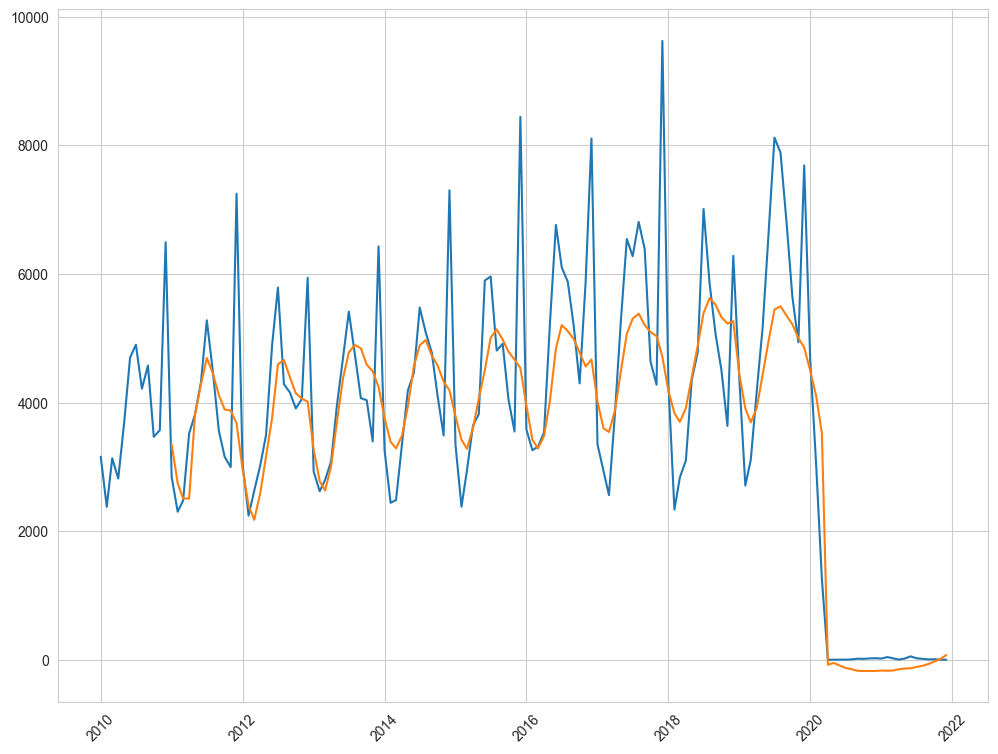

In [43]:
fig, ax = plt.subplots(figsize=(12,9))
sns.set_style("whitegrid")
ax.plot(palau["date"].values, palau["total"].values)
ax.plot(y_train_df["date"].values, y_train_df["total"].values)
# ax.plot(y_pred_df["date"].values, y_pred_df["total"].values, color="red")
plt.xticks(rotation=45)
plt.show()